In [22]:
import torch
import math
import pickle
import numpy as np
import torch.nn as nn
import torch.optim as optim
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import pandas as pd

In [23]:
data_file = '../dataset/'

In [24]:
traj_nodes = pickle.load(open(data_file + "traj_nodes_4k.pkl", "rb"))
traj_veh = defaultdict(list)
for k in traj_nodes:
    traj_veh[k['vehicle_id']] = np.array(
        k['xyt'])[:, :1].astype(int).reshape(-1).tolist()


def get_labels(records, labels, thres=0.9):
    if not isinstance(labels, list):
        labels = labels.tolist()
    pair = [
        (int(i["vehicle_id"]) if i["vehicle_id"] in traj_veh.keys() else -1, j)
        for i, j in zip(records, labels)
    ]
    pair.sort(key=lambda x: x[0])
    vid2cid = defaultdict(list)
    gt_size = defaultdict(int)
    cid_size = defaultdict(int)
    cid2vid = defaultdict(list)
    for i, j in pair:
        cid2vid[j].append(i)
        cid_size[j] += 1
        if i != -1:
            gt_size[i] += 1

    cidtovid = defaultdict(list)
    for i in cid2vid.keys():
        if sum(cid2vid[i]) != -len(cid2vid[i]):
            cidtovid[i] = cid2vid[i]

    return cidtovid


def get_vid(vid_list):  # 获得车辆ID众数
    cs = [i for i in vid_list]
    vid, cnt = max(Counter(cs).items(), key=lambda x: x[1])
    return vid

In [25]:
clu_path = "../dataset/"
records = pickle.load(open(data_file + "records_4w.pkl", "rb"))
labels07 = np.loadtxt(clu_path + "preds_4w_0.8.txt").astype(int).tolist()
labels09 = np.loadtxt(clu_path + "preds_4w_0.9.txt").astype(int).tolist()

In [26]:
inp_enc_data = defaultdict(list)
inp_dec_data = []
gt_data = []
df_records = pd.DataFrame(records)
clu_09 = get_labels(records, labels09)
for item, vid_list in clu_09.items():
    ans = df_records.iloc[np.array(labels09) == item, :]
    rec_ids = ans.record_id.values.tolist()
    vid = get_vid(vid_list)
    if vid == -1:
        continue
    inp_enc_data[vid].append(rec_ids)
# inp_enc_data

In [27]:
clu_07 = get_labels(records, labels07)

xy_data = defaultdict(list)

for item, vid_list in clu_07.items():
    ans = df_records.iloc[np.array(labels07) == item, :]
    rec_ids = ans.record_id.values.tolist()
    # inp_dec_data.append(rec_ids)
    vid = get_vid(vid_list)
    if vid == -1 or not vid in inp_enc_data.keys():
        continue
    gt_res = ans.vehicle_id.values == vid

    for val in inp_enc_data[vid]:
        if len(set(val)) > 1 and set(val).issubset(set(rec_ids)):
            enc_y = df_records[df_records.record_id.isin(
                val)].vehicle_id.values == vid
            xy_data['x_high'].append(val)  #
            xy_data['x'].append(rec_ids)
            xy_data['y'].append(vid)
            xy_data['gt_deno'].append(gt_res)
            xy_data['gt_nums'].append(
                (df_records.vehicle_id.values == vid).sum())
            break
len(clu_07.items())
len(xy_data['x'])

1166

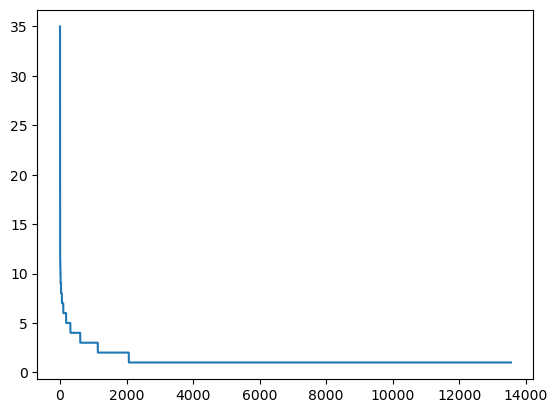

In [28]:
from collections import Counter

c = Counter(labels07)
c = dict(sorted(c.items(), key=lambda x: x[1], reverse=True))
plt.plot(np.arange(len(c)), c.values())
plt.show()


In [29]:
from torchnlp.encoders.text import StaticTokenizerEncoder

data = xy_data  # pickle.load(open(data_file + "data.pkl", "rb"))
G = pickle.load(open(data_file + "longhua_1.8k.pkl", "rb"))

In [30]:
cam_x_list_high = [[
    df_records[df_records['record_id'] == j].camera_id.values[0] for j in i
] for i in data['x_high']]
cam_x_tms_list_high = [[
    df_records[df_records['record_id'] == j].time.values[0] for j in i
] for i in data['x_high']]
cam_x_recd_list_high = data['x_high']

cam_x_list = [[
    df_records[df_records['record_id'] == j].camera_id.values[0] for j in i
] for i in data['x']]
cam_x_tms_list = [[
    df_records[df_records['record_id'] == j].time.values[0] for j in i
] for i in data['x']]
cam_x_recd_list = data['x']

for i, item in enumerate(cam_x_tms_list):
    idxs = np.argsort(np.array(item))
    cam_x_list[i] = np.array(cam_x_list[i])[idxs].tolist()
    cam_x_tms_list[i] = np.array(cam_x_tms_list[i])[idxs].tolist()
    cam_x_recd_list[i] = np.array(cam_x_recd_list[i])[idxs].tolist()

for i, item in enumerate(cam_x_tms_list_high):
    idxs = np.argsort(np.array(item))
    cam_x_list_high[i] = np.array(cam_x_list_high[i])[idxs].tolist()
    cam_x_tms_list_high[i] = np.array(cam_x_tms_list_high[i])[idxs].tolist()
    cam_x_recd_list_high[i] = np.array(cam_x_recd_list_high[i])[idxs].tolist()

cam_x_tms = defaultdict(list)
cam_x_recd = defaultdict(list)
cam_x = defaultdict(list)
cam_x_recd_high = defaultdict(list)
cam_x_high = defaultdict(list)
for i, vid in enumerate(data['y']):
    cam_x[vid] = cam_x_list[i]
    cam_x_tms[vid] = cam_x_tms_list[i]
    cam_x_recd[vid] = cam_x_recd_list[i]
    cam_x_high[vid] = cam_x_list_high[i]
    cam_x_recd_high[vid] = cam_x_recd_list_high[i]

In [31]:
cam_x_tms[vid]

[890, 891, 891, 892]

In [32]:
for node in G.nodes:
    x, y = G.nodes[node]['x'], G.nodes[node]['y']
    G.nodes[node]['xy'] = [x, y]
map_oid2nid = defaultdict()
for n in G.nodes():
    if isinstance(G.nodes()[n]['osmid_original'], int):
        map_oid2nid[G.nodes()[n]['osmid_original']] = n
        continue
    osmid = eval(G.nodes()[n]['osmid_original'])
    for oid in osmid:
        map_oid2nid[oid] = n

In [33]:
len(df_records.camera_id.values)

18108

In [34]:
df_traj = pd.DataFrame(traj_nodes)
res_seq = defaultdict(list)
for idx, i in enumerate(data['y']):
    if not sum(df_traj.vehicle_id == i):
        continue
    if i in res_seq.keys():
        continue
    for n in df_traj[df_traj.vehicle_id == i].xyt.values[0]:
        if n[0] in map_oid2nid.keys():
            res_seq[i].append(map_oid2nid[n[0]])
    res_seq[i] = [
        x for j, x in enumerate(res_seq[i]) if j == 0 or x != res_seq[i][j - 1]
    ]


In [35]:
import osmnx as ox

In [36]:
data_all = []
data_xx = []
outlier = []
used_vids = []
for i in res_seq.keys():
    if cam_x[i] == []:
        continue
    itsn = set(cam_x[i]) & set(res_seq[i])
    if len(itsn) > 0 and len(set(cam_x[i])) > 2:
        if set(cam_x[i]) - itsn:
            outlier.append(i)
        data_all.append(res_seq[i])
        data_xx.append(cam_x[i])
        if i in traj_veh.keys():
            used_vids.append(i)
print(len(data_all), len(data_xx), len(outlier), len(used_vids))

687 687 370 687


In [37]:
res_seq_clip_od = defaultdict(list)
cam_x_clip_od = defaultdict(list)
cam_x_tms_clip_od = defaultdict(list)
cam_x_recd_clip_od = defaultdict(list)
cam_x_high_clip_od = defaultdict(list)
cam_x_recd_high_clip_od = defaultdict(list)
for vid in used_vids:
    if cam_x[vid] is None:
        print(cam_x[vid])
    st = 0
    ed = len(res_seq[vid])
    for i, vlu in enumerate(cam_x[vid]):
        if vlu in res_seq[vid]:
            st = res_seq[vid].index(vlu)
            break
    for i, vlu in enumerate(cam_x[vid][::-1]):
        if vlu in res_seq[vid]:
            ed = len(res_seq[vid]) - res_seq[vid][::-1].index(vlu)
            break
    if ed - st > 2:
        res_seq_clip_od[vid] = res_seq[vid][st:ed]
        cam_x_clip_od[vid] = cam_x[vid][:]
        cam_x_tms_clip_od[vid] = cam_x_tms[vid][:]
        cam_x_recd_clip_od[vid] = cam_x_recd[vid][:]
        cam_x_high_clip_od[vid] = cam_x_high[vid][:]
        cam_x_recd_high_clip_od[vid] = cam_x_recd_high[vid][:]
# used_vids

In [38]:
for key in cam_x_clip_od.keys():
    lst = cam_x_clip_od[key]
    cam_x_clip_od[key] = [
        x for i, x in enumerate(lst) if i == 0 or x != lst[i - 1]
    ]
    ans = cam_x_tms_clip_od[key]
    cam_x_tms_clip_od[key] = [
        ans[i] for i, x in enumerate(lst) if i == 0 or x != lst[i - 1]
    ]
    ans = cam_x_recd_clip_od[key]
    cam_x_recd_clip_od[key] = [
        ans[i] for i, x in enumerate(lst) if i == 0 or x != lst[i - 1]
    ]


In [39]:
tklet = defaultdict(list)
tklet_wopad = defaultdict(list)
for key in cam_x_clip_od.keys():
    tklet_i = []
    tklet_i_wopad = []
    for vlu in cam_x_recd_clip_od[key]:
        ans = df_records[df_records.record_id == vlu].tklet_nodes.values[0]
        ans_wopad = ans[:]
        node = df_records[df_records.record_id == vlu].camera_id.values[0]

        if len(ans) == 0 or len(ans) == 1:
            ans = [
                list(G.predecessors(node))[0], node,
                list(G.successors(node))[0]
            ]
            ans_wopad = [node]
        if len(ans) == 2:
            ix = ans.index(node)
            if ix == 0:
                ans.insert(0, list(G.predecessors(node))[0])
            elif ix == 1:
                ans.insert(-1, list(G.successors(node))[0])
        tklet_i.extend(ans)
        tklet_i_wopad.extend(ans_wopad)
    # print(len(tklet_i))
    tklet[key] = tklet_i[1:-1]
    tklet_wopad[key] = tklet_i_wopad[:]
len(tklet.keys())

609

In [40]:
pickle.dump(
    {
        'cam_x': cam_x_clip_od,
        'tklet': tklet,
        'tklet_wopad': tklet_wopad,
        'recd_token': cam_x_recd_clip_od,
        'cam_x_high': cam_x_high_clip_od,
        'recd_token_high': cam_x_recd_high_clip_od,
        'cam_tms': cam_x_tms_clip_od,
        'traj_y': res_seq_clip_od,
    }, open(data_file + 'data_sim_4k.pkl', "wb"))

In [41]:
min([len(i) for i in res_seq_clip_od.values()])
# len(res_seq_clip_od)

3

In [42]:
# import tqdm
# for vid in tqdm.tqdm(res_seq_clip_od.keys()):
#     ans1 = cam_x_clip_od[vid]
#     gt_traj = res_seq_clip_od[vid]
#     nc = ['b' if node in ans1 else 'gray' for node in G.nodes()]
#     ns = [20 if node in ans1 else 1 for node in G.nodes()]
#     fig, ax = ox.plot_graph(G,
#                             node_color=nc,
#                             node_size=ns,
#                             show=False,
#                             bgcolor='w',
#                             edge_color='#dcdcdc')
#     ox.plot_graph_route(
#         G,
#         gt_traj,
#         ax=ax,
#         show=False,
#         save=True,
#         filepath=f"/root/lizhishuai/sim_3ddata/result_img/demo{vid}.png",
#         bgcolor='w',
#         edge_color='#dcdcdc')
